In [21]:
#######
import warnings
warnings.filterwarnings("ignore")
#####
import sys
# d_idx = eval(sys.argv[1])
d_idx = 446
nBins = 51
# if(len(sys.argv) == 3):
#     nBins = eval(sys.argv[2])
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm




In [2]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)



../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [18]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
lRange = (1., 2.*lMax)  # range for power spectra


# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

in_data = {}

# for fname in tqdm(IN_DATA_FNAMES):
#     f = open(fname, 'rb') 
#     c_in_data = pickle.load(f) 
#     f.close()
#     for key in c_in_data:
#         if(key not in in_data.keys()):
#             in_data[key] = np.array(c_in_data[key])
#         else:
#             in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))

    
pairs = [
#    [0,0], #N0
#    [0,1], #kappa
#    [1,0], #kappa
#    [0,2], #N1
#    [1,1], #N1
#    [2,0], #N1
#     [0,3], #should vanish
#     [1,2], #should vanish
#     [2,1], #should vanish
#     [3,0], #should vanish
#     [0,4], #N2 
#     [1,3], #N2
#     [2,2], #N2
#     [3,1], #N2
#     [4,0], #N2
   [-1, -1], #QE
   [-2, -2], #unlensed
]


data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}



data = {}

Map properties
CMB lensing power spectrum
Gets a theoretical prediction for the noise
computing the reconstruction noise


In [17]:
nBins = 51


In [22]:
def tmp_combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)
#     sCls =  np.sum(np.transpose(Cls_tot, axes=[1,2,0])[2], axis=1)
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))
    return lCen, Cls, sCls
ck = 'RDN(0)'


import multiprocessing as mp

def process_data(tmp_idx):
    oup_fname = '/scratch/users/delon/LensQuEst/RDN0-in_data-%d-%d.pkl' % (d_idx, tmp_idx)
    f = open(oup_fname, 'rb')
    RDN0_data = pickle.load(f)
    f.close()

    ds1 = RDN0_data['ds1']
    s1d = RDN0_data['s1d']
    s1s2 = RDN0_data['s1s2']
    s2s1 = RDN0_data['s2s1']
    curr_data = []

    for s, a, b in [[1, ds1, ds1], [1, ds1, s1d], [1, s1d, ds1], [1, s1d, s1d], [-1, s1s2, s1s2], [-1, s1s2, s2s1]]:
        t0, t1, t2 = baseMap.crossPowerSpectrum(dataFourier1=a, dataFourier2=b, nBins=nBins)
        curr_data.append([t0, s * t1, t2])

    c_ps_data = {}
    c_ps_data[ck] = [0, 0, 0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = tmp_combine_Cl(curr_data)

    return c_ps_data[ck]

pool = mp.Pool()

results = list(tqdm(pool.imap(process_data,  range(2500)), total=2500))


pool.close()
pool.join()

100%|█████████▉| 2499/2500 [00:25<00:00, 99.66it/s] 


UnpicklingError: pickle data was truncated

In [ ]:
tot = np.zeros_like(results[0])
tot[0] = results[0][0]
for result in results:
    assert(all(tot[0] == result[0]))
    tot[1] += result[1]
    tot[2] += np.square(result[2])

In [ ]:
tot[1] = tot[1] / (2500)
tot[2] = np.sqrt(tot[2])/ (2500)



In [ ]:
with open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-combined-%d-nBins%d.pkl'%(d_idx, nBins), "wb") as f:
    pickle.dump(tot, f)


(1.1e-10, 0.0009)

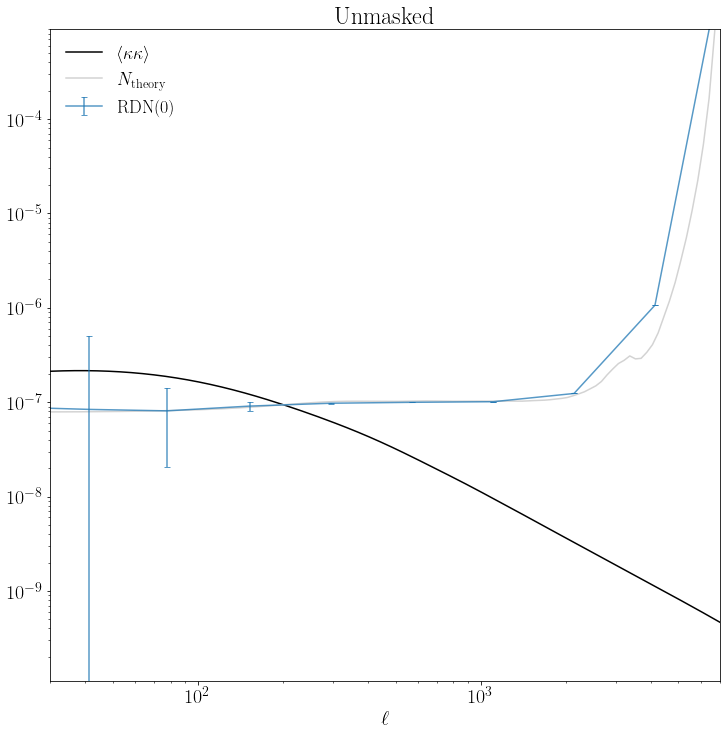

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20
factor = lambda l : 1
ell = baseMap.l.flatten()
theory=[fKK, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, factor(L)*ClExpected, sty, label=l)

Ipos = np.where(tot[1] > 0)
ax.errorbar(tot[0][Ipos], (tot[1][Ipos]), yerr=tot[2][Ipos], alpha=.75, 
                    fmt='-', capsize=3, capthick=1, label='RDN(0)')
    
ax.set_title('Unmasked')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(1.1e-10,.9e-3)

Gets a theoretical prediction for the noise
computing the reconstruction noise


(1.1e-10, 0.0009)

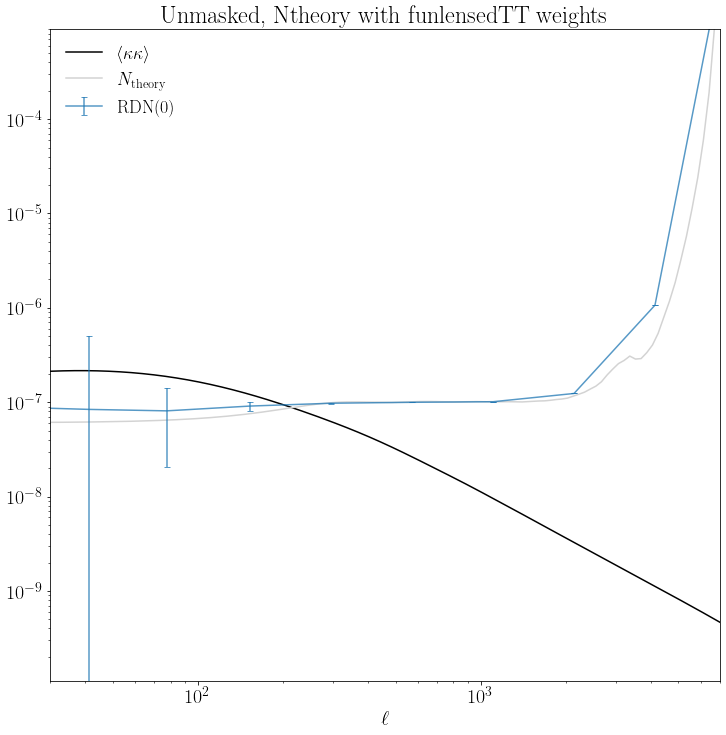

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20
factor = lambda l : 1
ell = baseMap.l.flatten()
theory=[fKK, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, factor(L)*ClExpected, sty, label=l)

Ipos = np.where(tot[1] > 0)
ax.errorbar(tot[0][Ipos], (tot[1][Ipos]), yerr=tot[2][Ipos], alpha=.75, 
                    fmt='-', capsize=3, capthick=1, label='RDN(0)')
    
ax.set_title('Unmasked, Ntheory with funlensedTT weights')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(1.1e-10,.9e-3)